This **notebook** is meant to explore the **dataset** and get a better understanding of the data.  
It enables to have more **insights**, raise **questions** and get some preliminary **leads** for the next steps.

***Import necessary libraries***

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

First things first, lets import the data set and take a look at it.

# Import the dataset 

The dataset is already split into `train` and `test` sets so we can directly import them.

In [63]:
train_data = pd.read_csv('data/raw_data/train.txt', names=['text', 'emotion'], sep=';')
test_data = pd.read_csv('data/raw_data/test.txt', names=['text', 'emotion'], sep=';')

# Analyze the dataset

## First look at the data

We can take a look at the train dataset for now.  
Starting with the number of **rows** and **columns**.

In [64]:
print("The dataset has {} rows and {} columns".format(*train_data.shape))

The dataset has 16000 rows and 2 columns


In [65]:
print("Column names: {}".format(train_data.columns.values))

Column names: ['text' 'emotion']


In [66]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


We can count, for each emotion, the number of samples in the train set.

In [67]:
train_data.emotion.value_counts() / train_data.shape[0] *100

emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

The data seems **unbalanced**, since we have `33%` of samples for the emotion "joy" and only `3%` for "surprise".  
We will see later that this have few impact on the **model performance**, but for now, since the data we are most likely to encounter in real life is **unbalanced**, we will keep it as it is.

## Distribution in the dataset

Let's take a look at the **distribution** of the samples in the train set.

In [75]:
def plot_emotion_distribution(data):
    col = 'emotion'
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
    explode = list((np.array(list(data[col].dropna().value_counts()))/sum(list(data[col].dropna().value_counts())))[::-1])[:10]
    labels = list(data[col].dropna().unique())[:10]
    sizes = data[col].value_counts()[:10]
    ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
    sns.countplot(y =col, data = data, ax=ax1)
    ax1.set_title("Total emotion count")
    ax2.set_title("Percentage of emotion")
    plt.show()

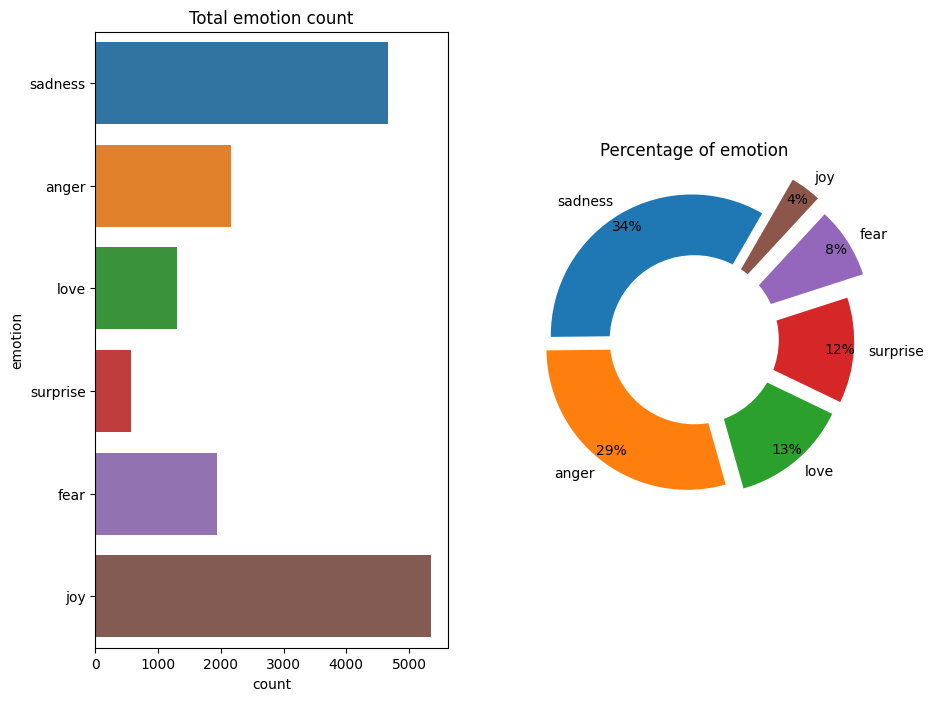

In [76]:
plot_emotion_distribution(train_data)

Looking at the distributions, we can see that there is approximately the same number of samples for `sadness` and `joy` (which are **opposite** so it's good news), as well as for `anger` and `fear` (which are **correlated** emotions so we can expect the model to have difficulties to distinguish them).

Lets do the same for the test set.

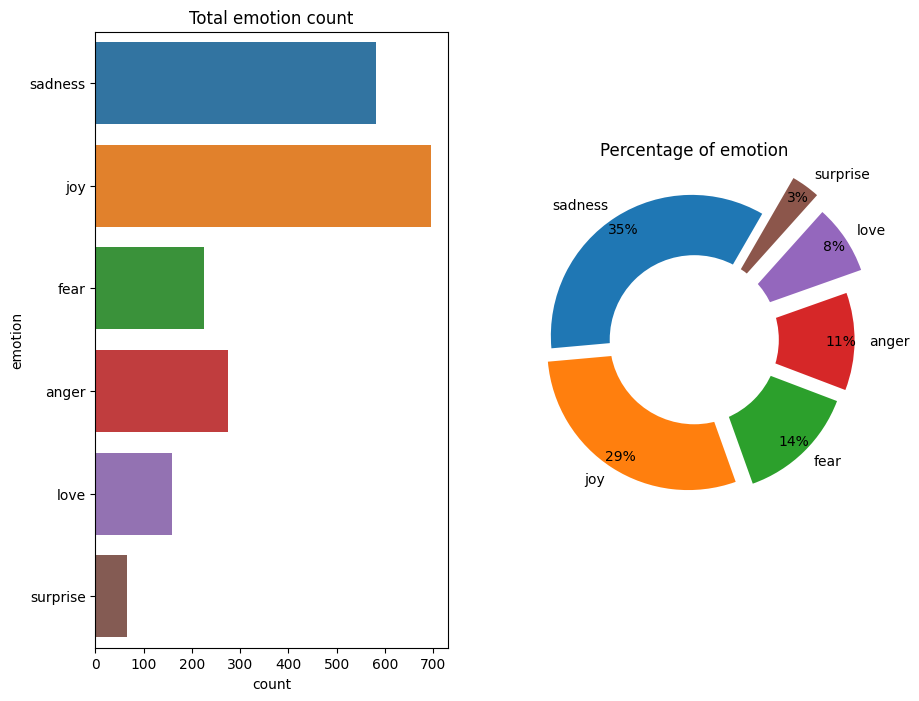

In [77]:
plot_emotion_distribution(test_data)

Since the **distribution** is similar, we can expect the model to **perform similarly** on the test set which is a good thing.

## Look for duplicates

In [70]:
train_data.isnull().sum()

text       0
emotion    0
dtype: int64

In [71]:
train_data[train_data['text'].duplicated() == True]

,text,emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


Since we are getting lots of duplicates in the dataset, we will remove them.

In [72]:
index = train_data[train_data['text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

We can check that the duplicates have been removed.

In [73]:
train_data[train_data['text'].duplicated() == True]

,text,emotion


Let's check for the test dataset as well.

In [79]:
test_data.duplicated().sum()

0

We could also make sure that there is no `data leaking` between the train and test sets, but since the test set comes from `kaggle`, we assume it is **clean** (see [here](https://www.kaggle.com/code/mohamedabdelmohsen/emotion-analysis-and-classification-using-lstm-93/notebook)).

## Character distribution

We could also take a look at the **distribution** of the characters lenghts in the dataset.  
That could enable to identify some **patterns** and see if there is some **cleaning** to do.

In [80]:
def plot_charater_length_distribution(data):
    data['char_length'] = data['text'].apply(lambda x : len(x))
    fig, ax = plt.subplots(figsize=(16,8))
    for sentiment in data['emotion'].value_counts().sort_values()[-5:].index.tolist():
        #print(sentiment)
        sns.kdeplot(data[data['emotion']==sentiment]['char_length'],ax=ax, label=sentiment)
    ax.legend()
    ax.set_title("Distribution of character length emotion-wise [Top 5 emotions]")
    plt.show()

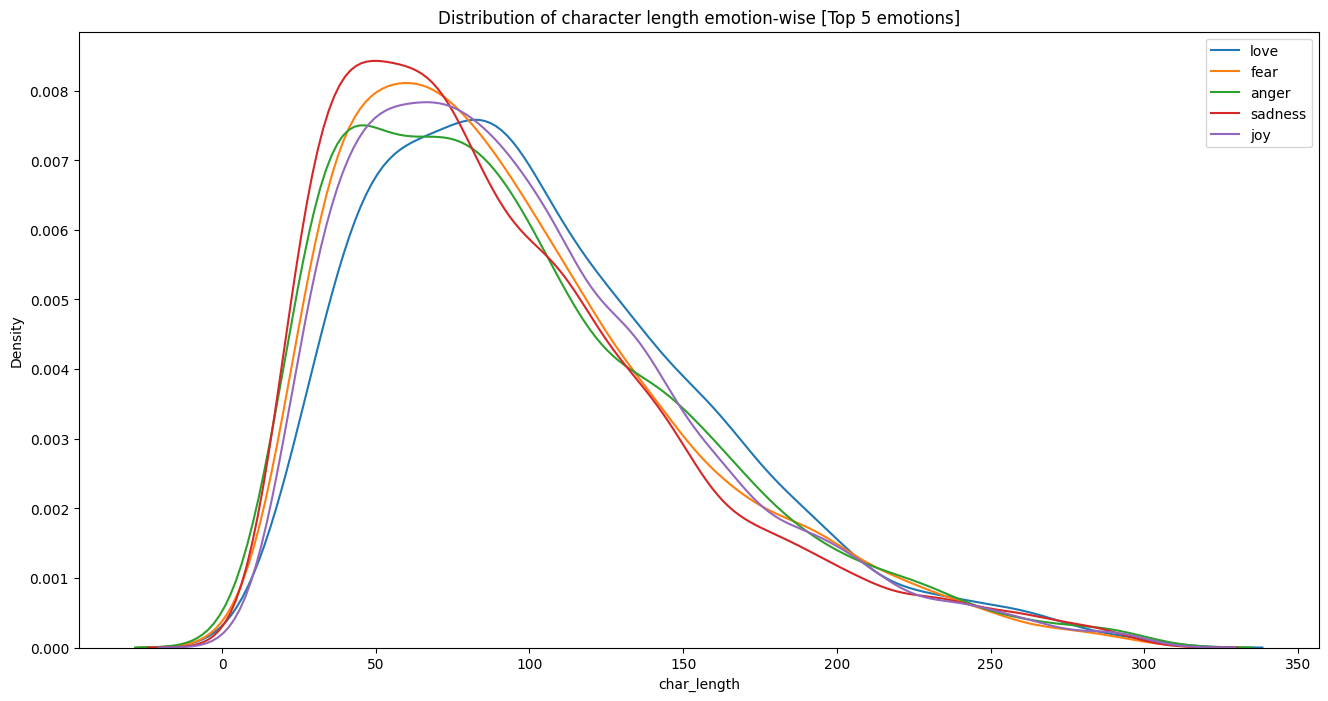

In [82]:
plot_charater_length_distribution(train_data)

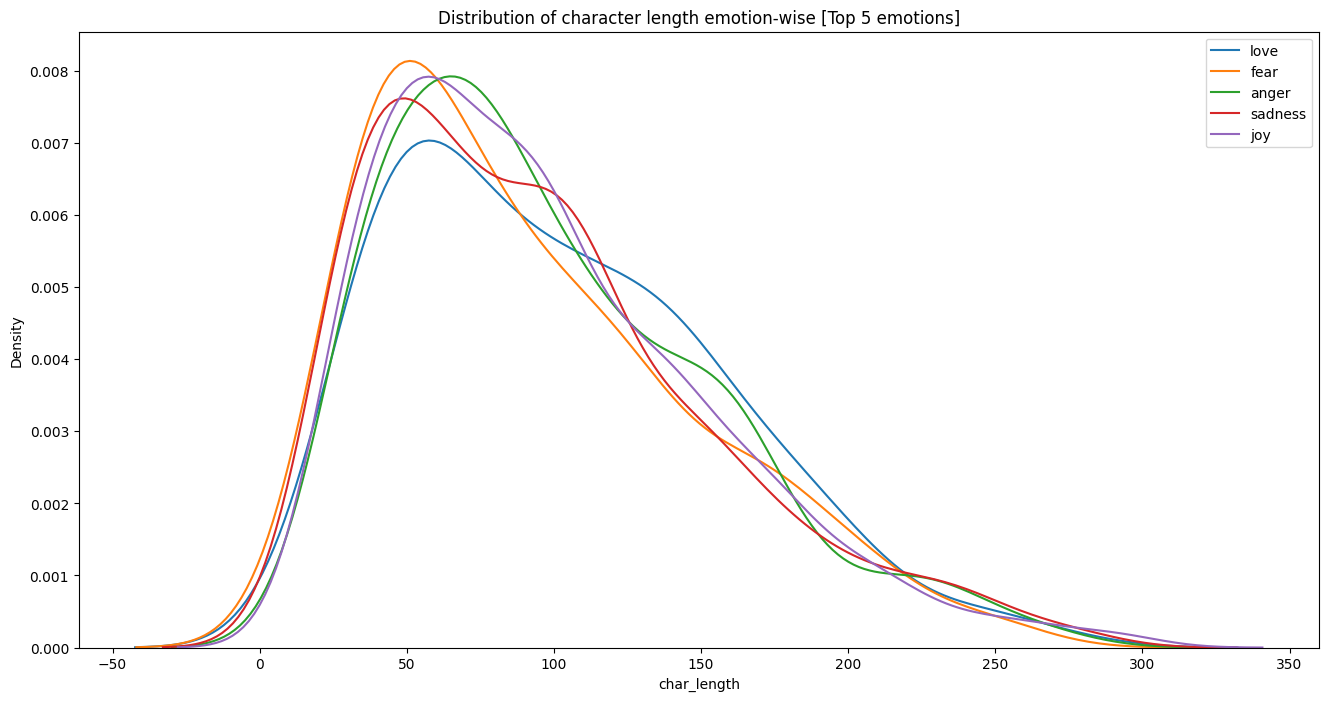

In [88]:
plot_charater_length_distribution(test_data)

Looking at the two graphs, we can't see **any obvious pattern**.  
No emotion seems to have a specific **character distribution**, for example we could have assume longer sentences for `sadness` or `anger`, but it doesn't seem to be the case.

## Wordcloud

Another interesting thing to do is to look at the **wordclouds** for each `emotion`.  
It enables to see the most **frequent words** for each emotion, hence gaining some **insights** on the data.

In [86]:
def plot_wordcloud(data, emotioninput):
    emottext  = data[data['emotion'] == emotioninput].text
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(emottext))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

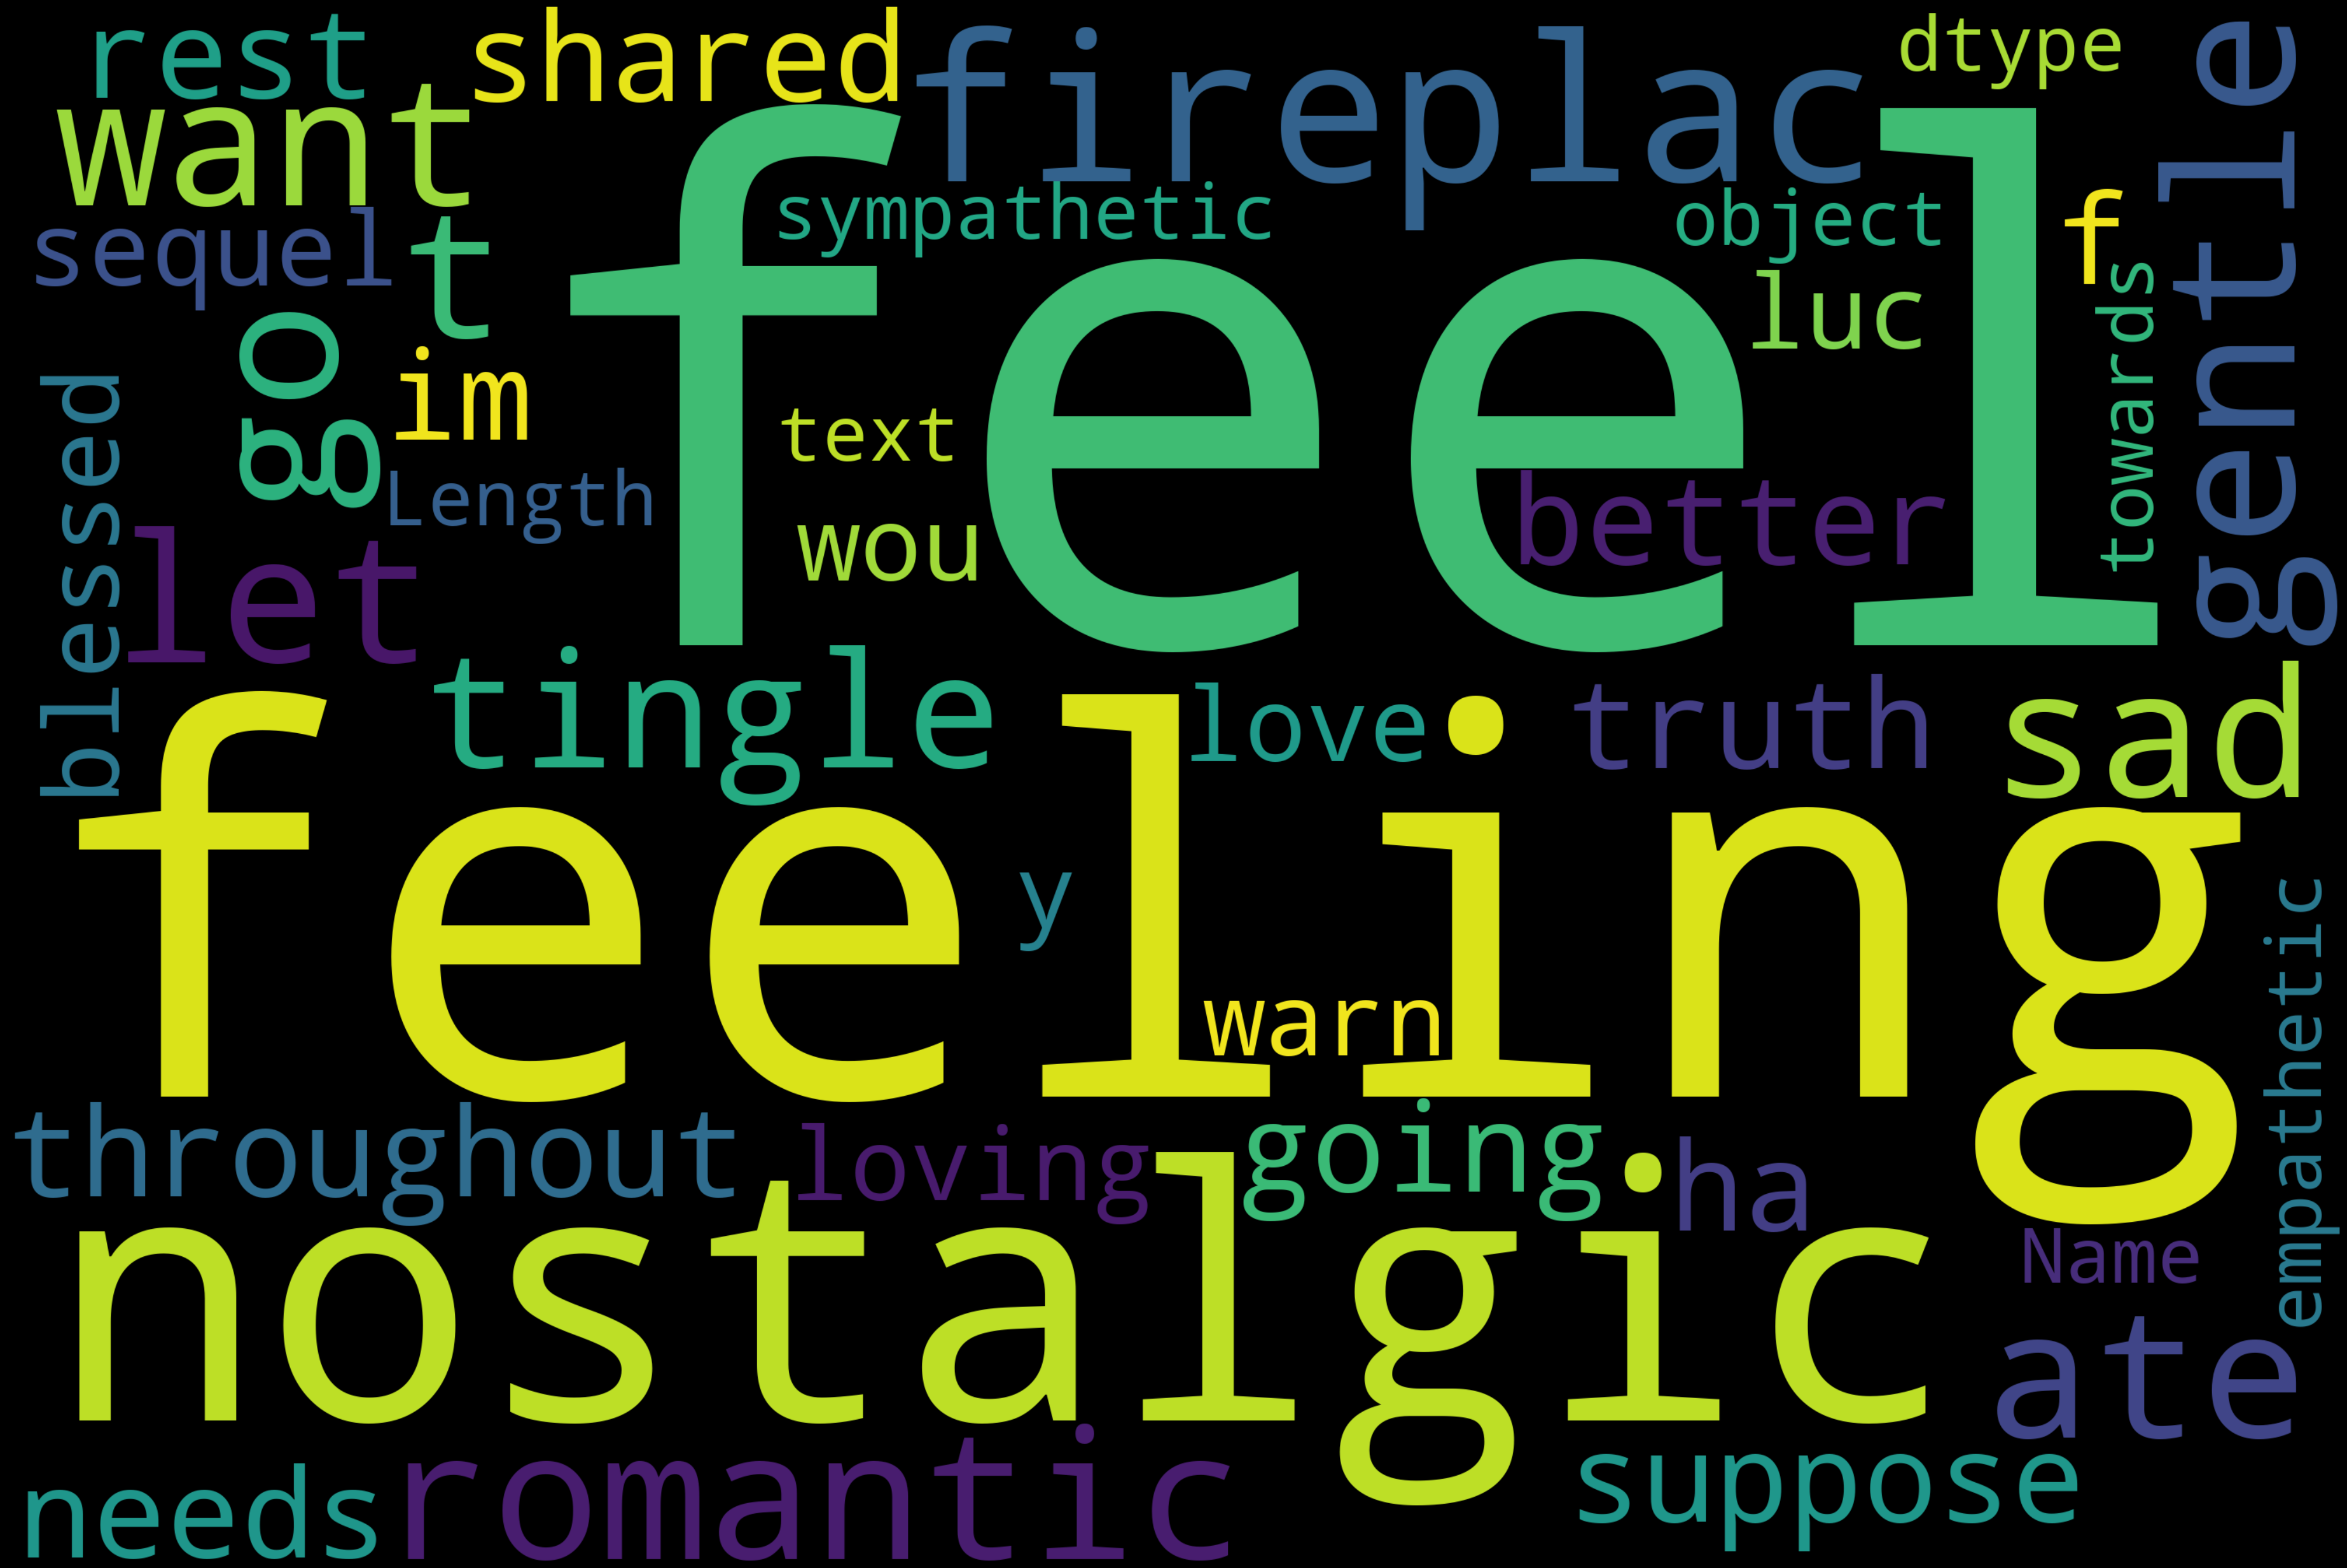

In [87]:
plot_wordcloud(train_data, 'love')

We can read words as nostalgic, loving, romantic, love and so on.

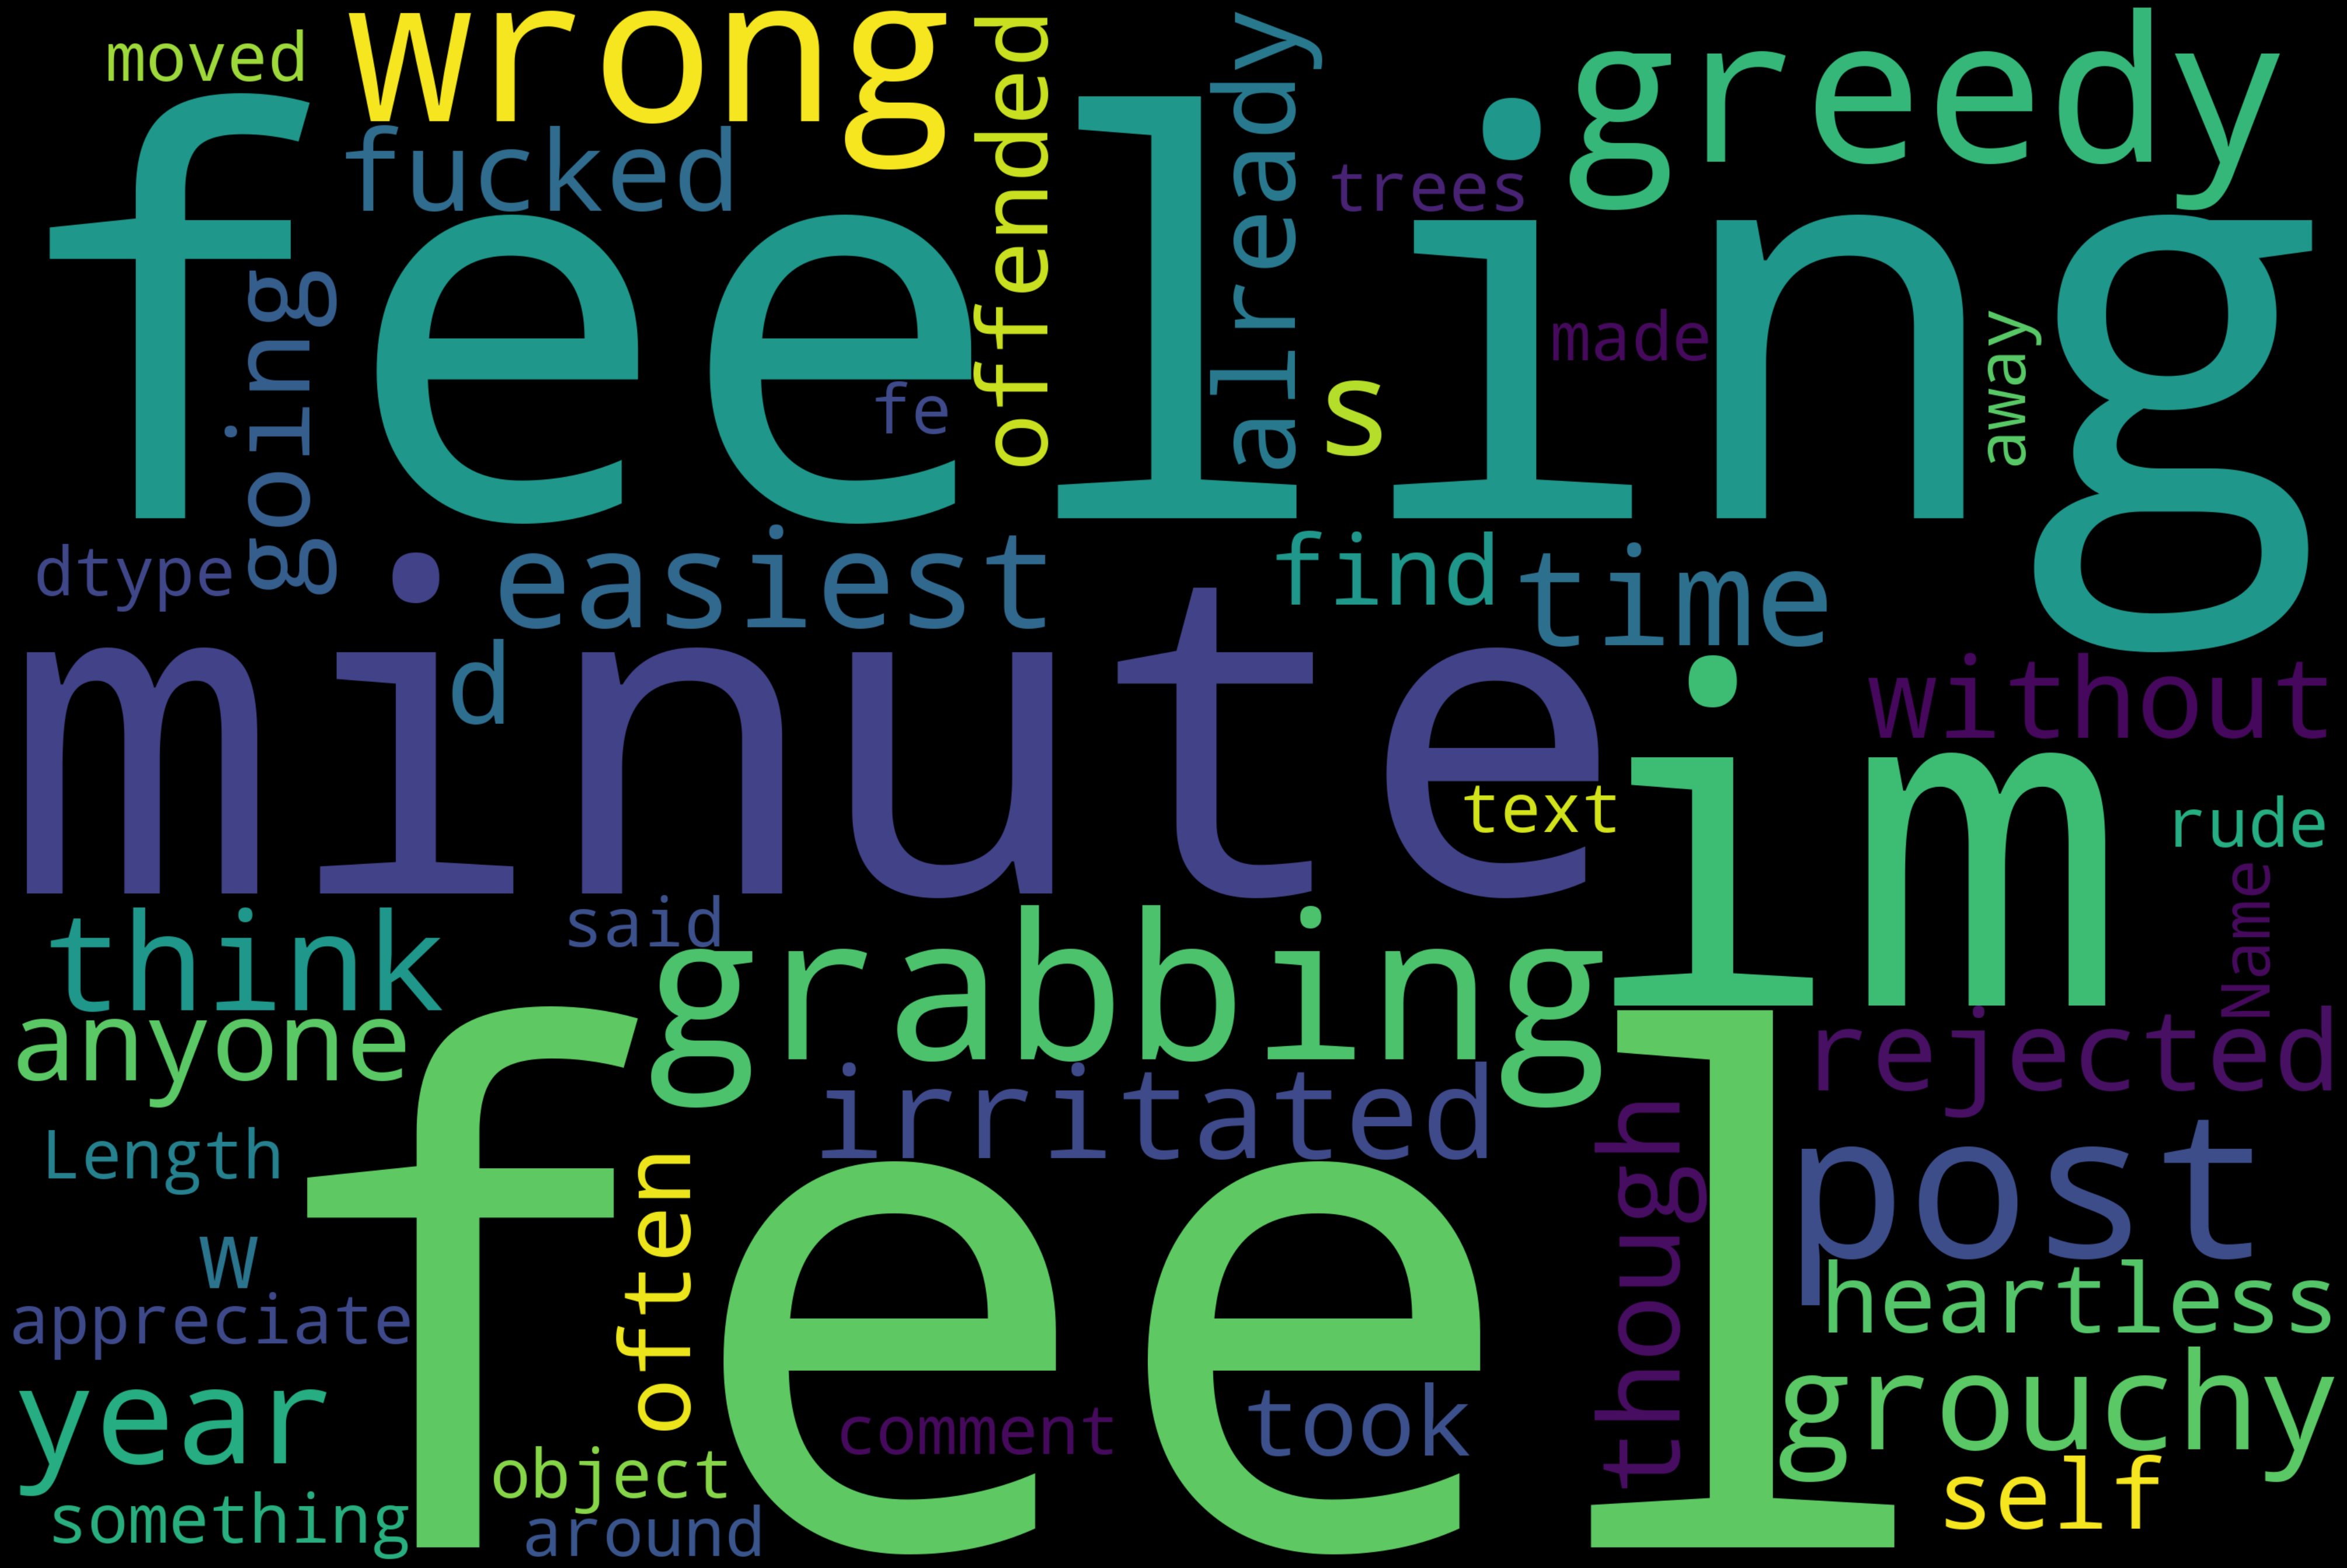

In [89]:
plot_wordcloud(train_data, 'anger')

We can read some words like wrong, greedy, offender, irritated and so on.

Next step is to `preprocess` the data and prepare it for the **model**.